In [50]:
pip install bokeh

In [2]:
pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [3]:
pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image
from matplotlib import patches

import random


from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
%matplotlib inline
import cv2
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 

There are very few images for training and testing. We must use data augemntation for this.

In [5]:
train_dir ='/content/drive/MyDrive/global_wheat/train/'
test_dir = '/content/drive/MyDrive/global_wheat/test/'
train_csv_path = '/content/drive/MyDrive/global_wheat/train.csv' 

In [6]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

In [7]:
train =pd.read_csv(train_csv_path)
train.head()

train_images = glob(train_dir+'*')
test_images = glob(test_dir+'*')
print("The images in train images are ",len(train_images))
print("The images in test images are ",len(test_images))

The images in train images are  3422
The images in test images are  10


In [8]:
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

**Step 2:** In the dataframe, we have records of every patches of a single image. We have to add all the patches and make it a single image.

In [9]:
#train_images
all_train_images = pd.DataFrame(i.split('/')[-1][:-4] for i in train_images)
all_train_images.columns = ['image_id']
all_train_images = all_train_images.merge(train,on = 'image_id',how='left')

In [10]:
all_train_images.head()

image_id   width  height                         bbox  source
0  b1642dc6f  1024.0  1024.0    [113.0, 26.0, 83.0, 80.0]  rres_1
1  b1642dc6f  1024.0  1024.0    [139.0, 93.0, 52.0, 62.0]  rres_1
2  b1642dc6f  1024.0  1024.0  [239.0, 153.0, 70.0, 112.0]  rres_1
3  b1642dc6f  1024.0  1024.0   [1.0, 194.0, 104.0, 102.0]  rres_1
4  b1642dc6f  1024.0  1024.0   [322.0, 186.0, 55.0, 88.0]  rres_1

In [11]:
all_train_images['bbox'] = all_train_images['bbox'].fillna('[0,0,0,0]')
bbox_items = all_train_images['bbox'].str.split(',',expand = True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(']').astype(float)

The DataFrame now contains the image id along with the grain patch x and y co-ordinate along with its width and height

In [12]:
all_train_images

image_id   width  height                         bbox     source  \
0       b1642dc6f  1024.0  1024.0    [113.0, 26.0, 83.0, 80.0]     rres_1   
1       b1642dc6f  1024.0  1024.0    [139.0, 93.0, 52.0, 62.0]     rres_1   
2       b1642dc6f  1024.0  1024.0  [239.0, 153.0, 70.0, 112.0]     rres_1   
3       b1642dc6f  1024.0  1024.0   [1.0, 194.0, 104.0, 102.0]     rres_1   
4       b1642dc6f  1024.0  1024.0   [322.0, 186.0, 55.0, 88.0]     rres_1   
...           ...     ...     ...                          ...        ...   
147837  229d8a499  1024.0  1024.0   [928.0, 785.0, 96.0, 56.0]  arvalis_3   
147838  229d8a499  1024.0  1024.0  [920.0, 902.0, 104.0, 55.0]  arvalis_3   
147839  229d8a499  1024.0  1024.0   [655.0, 50.0, 52.0, 125.0]  arvalis_3   
147840  229d8a499  1024.0  1024.0   [942.0, 739.0, 82.0, 56.0]  arvalis_3   
147841  229d8a499  1024.0  1024.0   [961.0, 833.0, 63.0, 48.0]  arvalis_3   

        bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0           113.0       26.0        83.0         80.0  
1           139.0       93.0        52.0         62.0  
2           239.0      153.0        70.0        112.0  
3             1.0      194.0       104.0        102.0  
4           322.0      186.0        55.0         88.0  
...           ...        ...         ...          ...  
147837      928.0      785.0        96.0         56.0  
147838      920.0      902.0       104.0         55.0  
147839      655.0       50.0        52.0        125.0  
147840      942.0      739.0        82.0         56.0  
147841      961.0      833.0        63.0         48.0  

[147842 rows x 9 columns]

In [14]:
print("Images without heads is",len(all_train_images)-len(train))

Images without heads is 49


**Step 3:** Plot the images along with the patches to find the amount of grain in it.


We create two function, one to get the coordinates of the patches and one to merge the image of the wheat along with its grain patches

In [15]:
def get_all_boxes(df,image_id):
    bboxes = []
    image_bbox = df[df.image_id==image_id]
    for _,rows in image_bbox.iterrows():
        bboxes.append((rows.bbox_xmin,rows.bbox_ymin,rows.bbox_width,rows.bbox_height))
        
    return bboxes

def plot_image_examples(df,rows= 3,columns=3,title ='Image Examples'):
    fig,axs = plt.subplots(rows,columns,figsize=(10,10))
    for row in range(rows):
        for col in range(columns):
            idx = np.random.randint(len(df),size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(train_dir + img_id + '.jpg')
            
            axs[row,col].imshow(img)
            
            bboxes = get_all_boxes(df,img_id)
            
            for bbox in bboxes:
                
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[2],edgecolor='r',linewidth=1,facecolor='none')
                axs[row,col].add_patch(rect)
                
            axs[row,col].axis('off')
            
    plt.suptitle(title)    

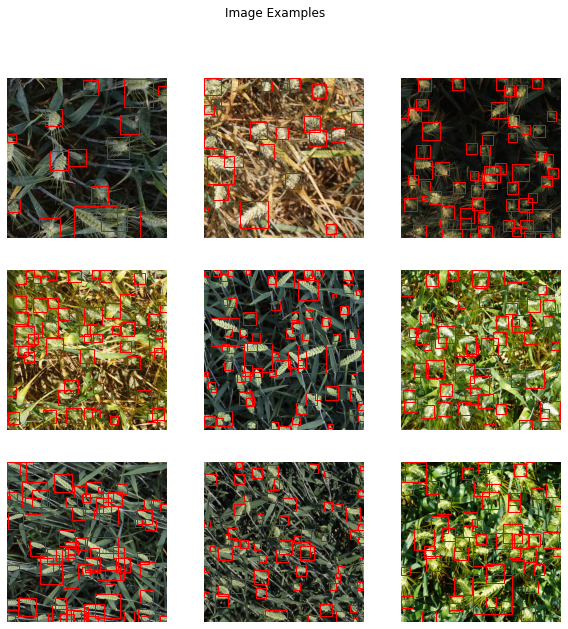

In [16]:
plot_image_examples(all_train_images)

We can see images taken at different lightining conditions and different maturity stages.

In [17]:
all_train_images['width'].value_counts()

1024.0    147793
Name: width, dtype: int64

**Step 4 :** We find about different features of the dataset by visualization

Count numbers of bounding boxe

In [18]:
all_train_images['counts'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0,axis =1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()

In [19]:
train_images_count

image_id    width   height  bbox_xmin  bbox_ymin  bbox_width  \
0     00333207f  56320.0  56320.0    26091.0    23051.0      4792.0   
1     005b0d8bb  20480.0  20480.0     8635.0     9267.0      2739.0   
2     006a994f7  25600.0  25600.0    13033.0    11204.0      2856.0   
3     00764ad5d  41984.0  41984.0    18309.0    18637.0      3951.0   
4     00b5c6764      0.0      0.0        0.0        0.0         0.0   
...         ...      ...      ...        ...        ...         ...   
3417  ffbb9c623      0.0      0.0        0.0        0.0         0.0   
3418  ffbf75e5b  53248.0  53248.0    22647.0    23920.0      4454.0   
3419  ffbfe7cc0  34816.0  34816.0    17561.0    16490.0      2899.0   
3420  ffc870198  41984.0  41984.0    17754.0    18419.0      5078.0   
3421  ffdf83e42  39936.0  39936.0    17112.0    22335.0      3118.0   

      bbox_height  counts  
0          3846.0      55  
1          2410.0      20  
2          2835.0      25  
3          3361.0      41  
4             0.0       0  
...           ...     ...  
3417          0.0       0  
3418       4691.0      52  
3419       3040.0      34  
3420       3765.0      41  
3421       2684.0      39  

[3422 rows x 8 columns]

 See this article on how to plot bar charts with Bokeh:
 https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3

In [56]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [57]:
hist_hover(train_images_count,'counts','Number of wheat spikes per image')

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "N" [renderer: GlyphRenderer(id='1285', ...)]


As we look at the plot,we find that most of the counts are in range 20-65.

In [58]:
#Lets plot some image with less number of count
less_spikes = train_images_count[train_images_count['counts']<10].image_id

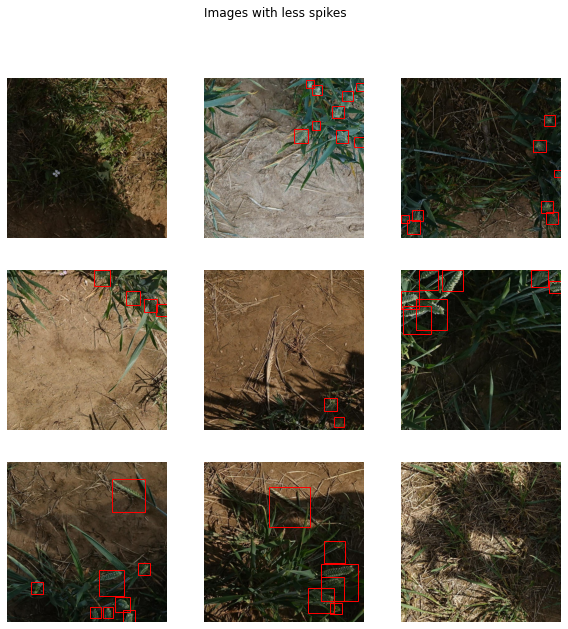

In [59]:
plot_image_examples(all_train_images[all_train_images.image_id.isin(less_spikes)],title = 'Images with less spikes')

Observations:

Most of the example have more ground

Most of them are zoomed too much

In [60]:
#Plotting the images with highest spikes
more_spikes = train_images_count[train_images_count['counts']>100].image_id

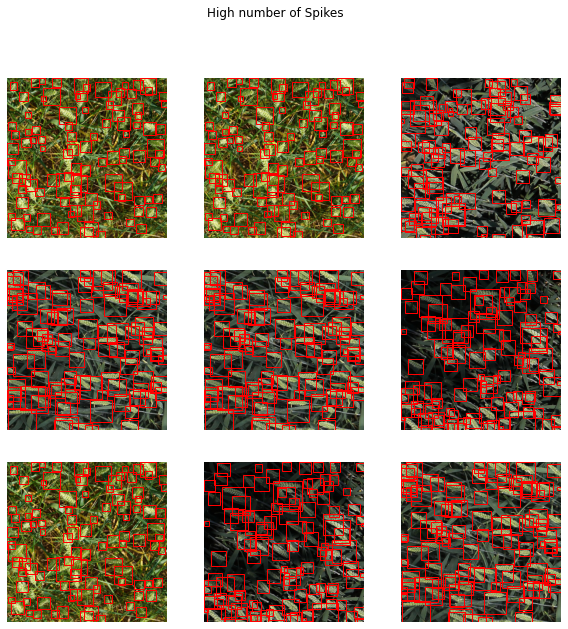

In [61]:
plot_image_examples(all_train_images[all_train_images.image_id.isin(more_spikes)],title= 'High number of Spikes')

As you can observe the number of spikes are much higher


Now we will calculate the area of bounding boxes

In [62]:
all_train_images['bbox_area'] = all_train_images['bbox_width']*all_train_images['bbox_height']

In [63]:
hist_hover(all_train_images,'bbox_area',title ='Area of a single bounding box')

In [64]:
#The max area of bounding box
max(all_train_images['bbox_area'])

529788.0

The distribution of Area of bbox is in very wide range. Lets look at the highest bbox areas

In [65]:
large_area = all_train_images[all_train_images['bbox_area'] >200000].image_id

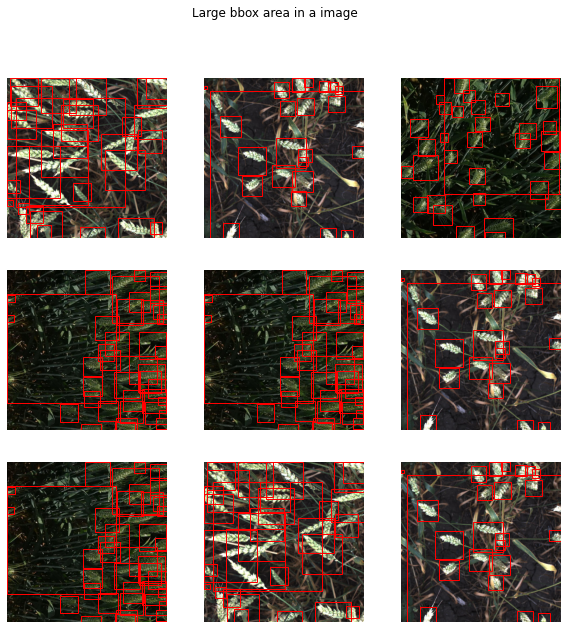

In [66]:
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_area)],title = 'Large bbox area in a image')

As you can see there are many anomally outliers in this images and they will cause a problem when we train, so its better to remove them

Lets also check the images with small bbox area

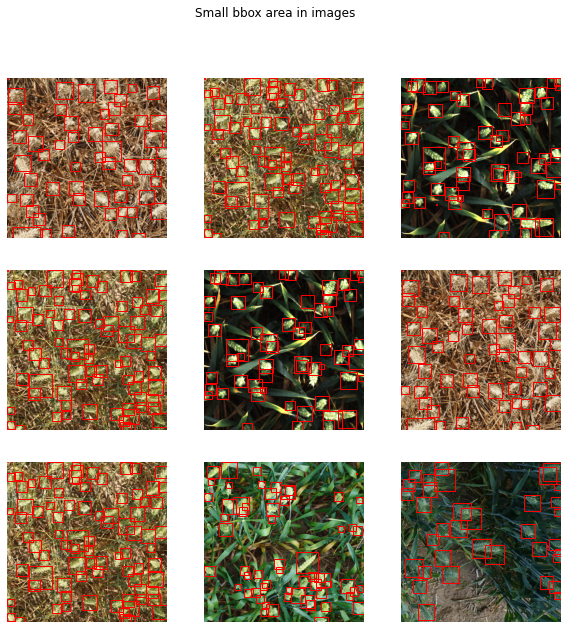

In [68]:
small_area = all_train_images[all_train_images['bbox_area']<50].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_area)],title='Small bbox area in images')

In [69]:
area_per_image = all_train_images.groupby("image_id").sum().reset_index()

In [70]:
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image['bbox_area']/(1024*1024)*100

In [71]:
area_per_image.head()

image_id    width   height  bbox_xmin  bbox_ymin  bbox_width  bbox_height  \
0  00333207f  56320.0  56320.0    26091.0    23051.0      4792.0       3846.0   
1  005b0d8bb  20480.0  20480.0     8635.0     9267.0      2739.0       2410.0   
2  006a994f7  25600.0  25600.0    13033.0    11204.0      2856.0       2835.0   
3  00764ad5d  41984.0  41984.0    18309.0    18637.0      3951.0       3361.0   
4  00b5c6764      0.0      0.0        0.0        0.0         0.0          0.0   

   counts  bbox_area  
0      55   350646.0  
1      20   322221.0  
2      25   325189.0  
3      41   330871.0  
4       0        0.0

In [72]:
area_per_image_percentage.head()
# the percentage of area covered by the BBox 

image_id    width   height  bbox_xmin  bbox_ymin  bbox_width  bbox_height  \
0  00333207f  56320.0  56320.0    26091.0    23051.0      4792.0       3846.0   
1  005b0d8bb  20480.0  20480.0     8635.0     9267.0      2739.0       2410.0   
2  006a994f7  25600.0  25600.0    13033.0    11204.0      2856.0       2835.0   
3  00764ad5d  41984.0  41984.0    18309.0    18637.0      3951.0       3361.0   
4  00b5c6764      0.0      0.0        0.0        0.0         0.0          0.0   

   counts  bbox_area  
0      55  33.440208  
1      20  30.729389  
2      25  31.012440  
3      41  31.554317  
4       0   0.000000


This shows the plot of how much percentage of image area is covered by bbox

In [73]:
hist_hover(area_per_image_percentage,'bbox_area',title ='Percentage of image covered by bbox')

As per the plot, most of the percentage lies in between 18% to 36% We have to check in with the lowest and the highest perecentage covered by bbox

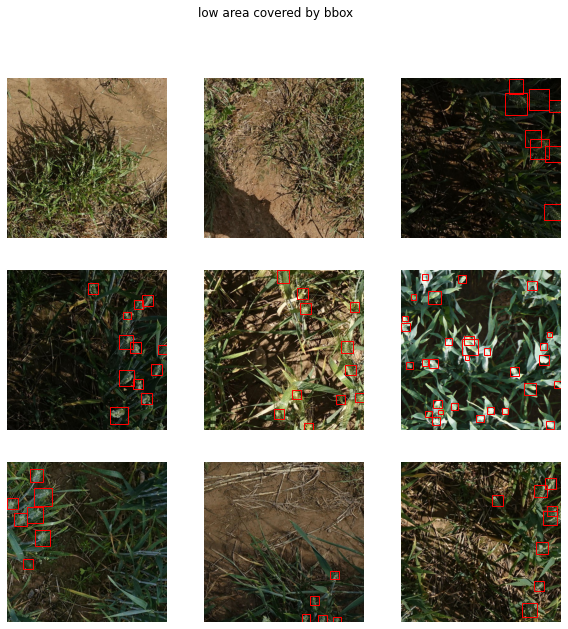

In [75]:
small_percentage = area_per_image_percentage[area_per_image_percentage['bbox_area']<8].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_percentage)],title='low area covered by bbox')

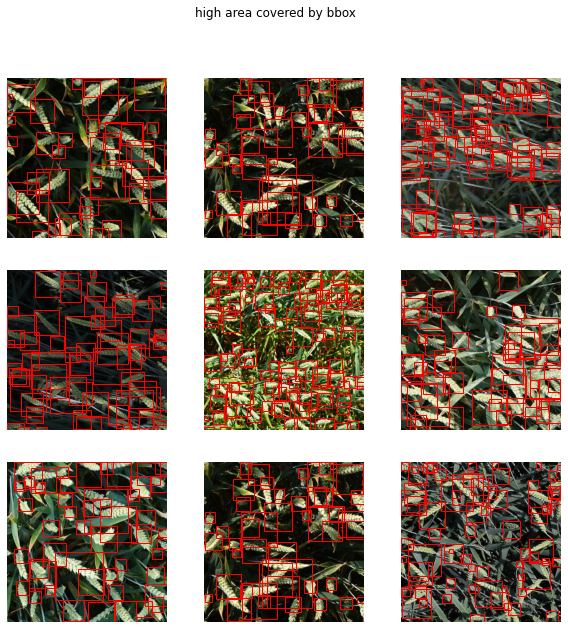

In [76]:
high_percentage = area_per_image_percentage[area_per_image_percentage['bbox_area']>50].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(high_percentage)],title='high area covered by bbox')

Lets plot w.r.t to brightness

In [77]:
def get_brightness(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return np.array(gray).mean()
    
def add_brightness(df):
    
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id
        image = cv2.imread(train_dir+img_id+'.jpg')
        brightness.append(get_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df,brightness_df],ignore_index = True,axis=1)
    df.columns = ['image_id','brightness']
    
    return df


In [79]:
image_df = pd.DataFrame(all_train_images.image_id.unique())

In [80]:
image_df.columns = ['image_id']

In [81]:

brightness_df = add_brightness(image_df)

all_train_images = all_train_images.merge(brightness_df,on='image_id')

In [82]:
hist_hover(all_train_images,'brightness',title ='Brightness in images')

All though, there is a peak the brightness ranges from to 116. Lets check out the outliers.

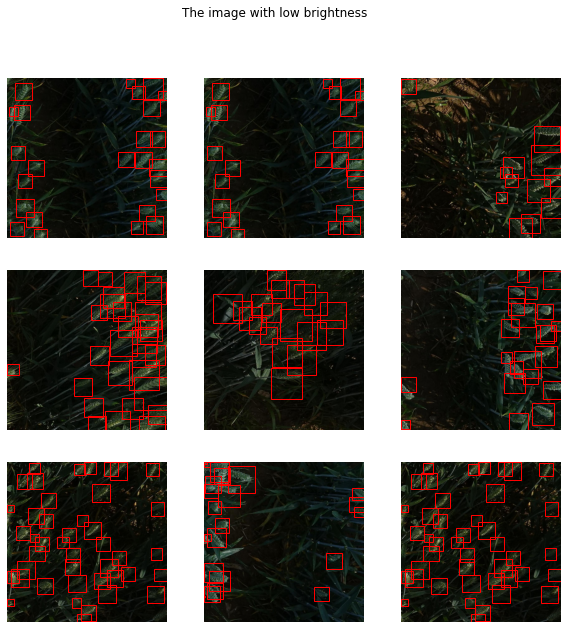

In [83]:
dark_ids = all_train_images[all_train_images['brightness']<25].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(dark_ids)],title='The image with low brightness')

As you can see, Its harder for even humans to detect.

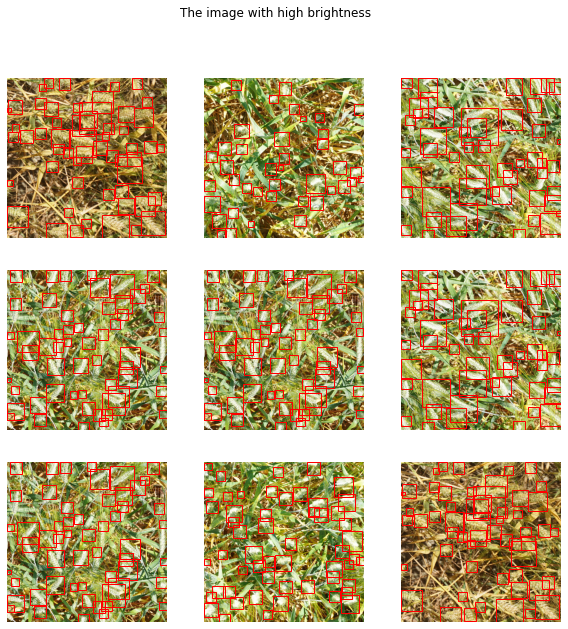

In [84]:
bright_ids = all_train_images[all_train_images['brightness']>130].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(bright_ids)],title='The image with high brightness')

They are very different from the dark images

Now,we should know that color represents a important part because it shows much far from harvest it is. If its Green it requires more time, If its brown, it have ground in them and if its Yellow, its ready to be harvested.

In [85]:
def green_pixels(image):
    img = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    
    #Get the green mask. I got from "https://stackoverflow.com/questions/47483951/how-to-define-a-threshold-value-to-detect-only-green-colour-objects-in-an-image"
    low =(40,40,40)
    high = (70,255,255)
    green_mask = cv2.inRange(img,low,high)
    
    return float( np.sum(green_mask))/255/(1024*1024)

def yellow_pixels(image):
    img = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    low= (25,40,40)
    high = (35,255,255)
    yellow_mask = cv2.inRange(img,low,high)
    
    return float(np.sum(yellow_mask))/255/(1024*1024)

def add_green(df):
    
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id
        image = cv2.imread(train_dir+img_id+'.jpg')
        brightness.append(green_pixels(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['green_bright']
    df = pd.concat([df,brightness_df],ignore_index = True,axis=1)
    df.columns = ['image_id','green_bright']
    
    return df

def add_yellow(df):
    
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id
        image = cv2.imread(train_dir+img_id+'.jpg')
        brightness.append(yellow_pixels(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['yellow_bright']
    df = pd.concat([df,brightness_df],ignore_index = True,axis=1)
    df.columns = ['image_id','yellow_bright']
    
    return df

In [87]:
green_pixels_df = add_green(image_df)
all_train_images = all_train_images.merge(green_pixels_df,on='image_id')

In [88]:
#Now lets plot on green color pixels

hist_hover(all_train_images,'green_bright',title ='Green Colors in images')

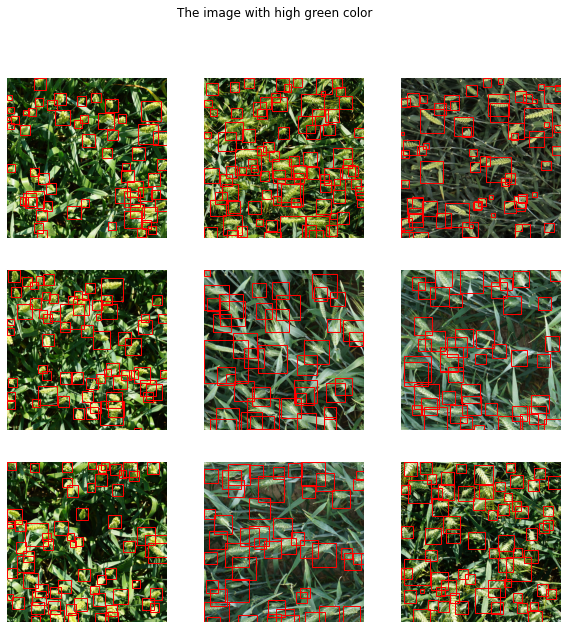

In [89]:
green_ids = all_train_images[all_train_images['green_bright']>0.4].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(green_ids)],title='The image with high green color')

The green color suggests that plant is grown near by and doesn't have that much spikes in it

In [90]:
yellow_pixels_df = add_yellow(image_df)
all_train_images = all_train_images.merge(yellow_pixels_df,on='image_id')

In [91]:
hist_hover(all_train_images,'yellow_bright',title ='yellow Colors in images')

Lets see the images with high yellow color

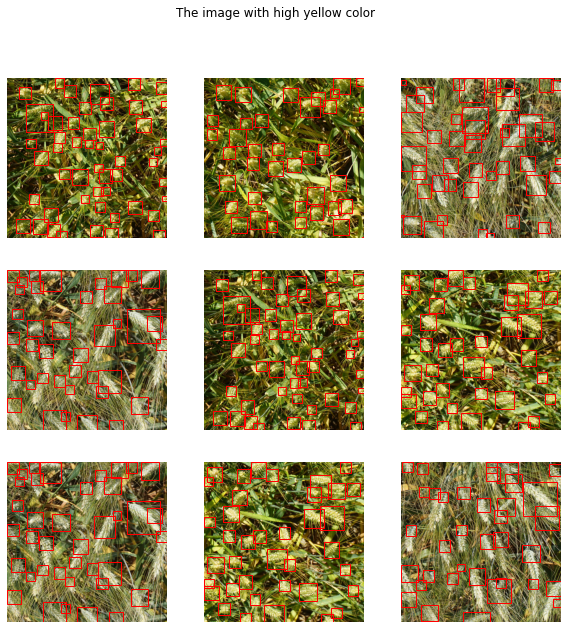

In [92]:
yellow_ids = all_train_images[all_train_images['yellow_bright']>0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(yellow_ids)],title='The image with high yellow color')

As you can see the images with high yellow pixels are ready to be harvest

# Why Data Augementation is Important
As we can see the training image is very less and its then the model will Underfit, thats why we will use albumentation to create new images by augementing them

In [20]:
import albumentations as al
example = al.Compose([
    al.RandomSizedBBoxSafeCrop(512,512,erosion_rate=0.0,interpolation=1,p=1.0),
    al.HorizontalFlip(p=0.5),
    al.VerticalFlip(p=0.5),
    al.OneOf([al.RandomContrast(),
              al.RandomGamma(),
              al.RandomBrightness()],p=1.0),
              al.CLAHE(p=0.1)],bbox_params= al.BboxParams(format='coco', label_fields=['category_id']), p=1.0
              )



/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [21]:
def apply_transform(transforms,df,n_transforms=3):
    idx = np.random.randint(len(df),size=1)[0]
    bboxes = []
    image_id = df.iloc[idx].image_id
    image_bbox = df[df.image_id==image_id]
    for _,rows in image_bbox.iterrows():
        bboxes.append([rows.bbox_xmin,rows.bbox_ymin,rows.bbox_width,rows.bbox_height])
        
    


            
    img = Image.open(train_dir + image_id + '.jpg')
            
    fix,axs = plt.subplots(1,n_transforms+1,figsize=(15,7))
            
    axs[0].imshow(img)
    axs[0].set_title("Original")
            
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],edgecolor='r',linewidth=1,facecolor='none')
        axs[0].add_patch(rect)
                
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(img),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()



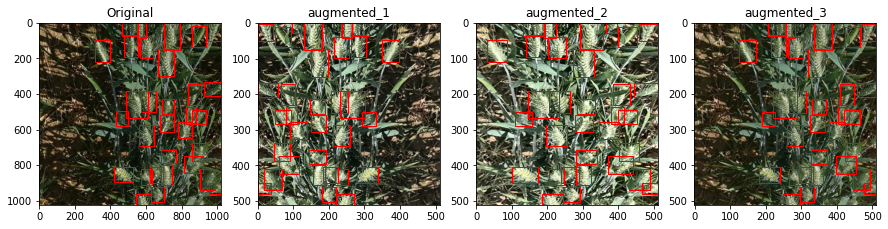

In [22]:
apply_transform(example,all_train_images,n_transforms=3)

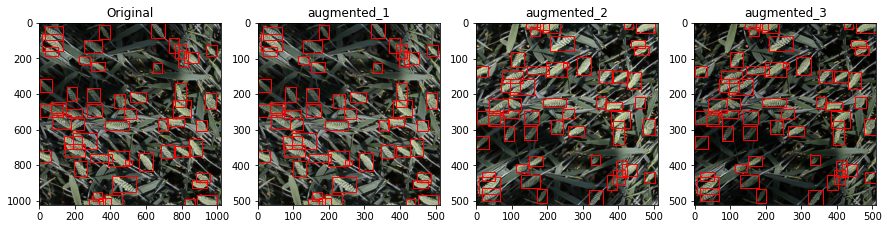

In [23]:
apply_transform(example,all_train_images,n_transforms=3)